In [1]:
from __future__ import print_function

import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import RMSprop, Adadelta, Adagrad, Adam, Nadam, SGD
from keras.callbacks import EarlyStopping, TerminateOnNaN
from keras import backend as K
from keras.losses import mean_squared_error
import tensorflow as tf

# Normalize the data.
from sklearn import preprocessing
from keras.regularizers import l1_l2
import scipy.io as spio
import random

def pass_arg(nsim, tr_size, dropoutrate):
    print("Tr_size:", tr_size)
    def fix_seeds(seed):
        random.seed(seed)
        np.random.seed(seed)
        tf.random.set_seed(seed)
        session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
        sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
        # K.set_session(sess)
        tf.compat.v1.keras.backend.set_session(sess)

    ss = 1
    fix_seeds(ss)

    # MC dropout
    class MCDropout(Dropout):
        def call(self, inputs, training=None):
            return super(MCDropout, self).call(inputs, training=True)

    # Compute the RMSE given the ground truth (y_true) and the predictions(y_pred)
    def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true), axis=-1))

    # Making sure final porosity is less than initial
    def poros(poroi, porof):
        porofn = -porof*(porof<0)
        porofp = porof*(porof>=poroi) - poroi*(porof>=poroi)
        return porofp+porofn

    def phy_loss_mean(params):
        # useful for cross-checking training
        loss1, loss2, loss3, loss4, lam1, lam2 = params
        x1, x2, x3 = loss1*(loss1>0), loss2*(loss2>0), loss3*(loss3>0)
    #     print(np.mean(x1), x1.shape[0])
    #     print(np.mean(x2), x2.shape[0])
    #     print(np.mean(x3), x3.shape[0])

        if x1.any() and x1.shape[0]>1:
            X_scaled1 = (x1 - np.min(x1)) / (np.max(x1) - np.min(x1))
            x1 = X_scaled1
        if x2.any() and x2.shape[0]>1:
            X_scaled2 = (x2 - np.min(x2)) / (np.max(x2) - np.min(x2))
            x2 = X_scaled2
        if x3.any() and x3.shape[0]>1:
            X_scaled3 = (x3 - np.min(x3)) / (np.max(x3) - np.min(x3))
            x3 = X_scaled3
        return (lam1*np.mean(x1) + lam2*np.mean(x2) + lam2*np.mean(x3))
    #     return (lam1*np.mean(x1) + lam2*np.mean(x2) + lam2*np.mean(x3) + lam2*loss4)

    def PGNN_train_test(optimizer_name, optimizer_val, drop_rate, iteration, n_layers, n_nodes, tr_size, lamda, reg):

        # Hyper-parameters of the training process
        # batch_size = int(tr_size/2)
        batch_size = 1000
        num_epochs = 1500
        val_frac = 0.2
        patience_val = 100

        # Initializing results filename
        exp_name = optimizer_name + '_drop' + str(drop_rate) + '_nL' + str(n_layers) + '_nN' + str(n_nodes) + '_trsize' + str(tr_size) + '_iter' + str(iteration)
        exp_name = exp_name.replace('.','pt')
        results_dir = '../results/'
        model_name = results_dir + exp_name + '_NoPhyInfomodel.h5' # storing the trained model
        if reg:
            results_name = results_dir + exp_name + '_results_regularizer.dat' # storing the results of the model
        else:
            results_name = results_dir + exp_name + '_results.dat' # storing the results of the model

        #List of lakes to choose from
        lake = ['mendota' , 'mille_lacs']
        lake_num = 0  # 0 : mendota , 1 : mille_lacs
        lake_name = lake[lake_num]

        # Load features (Xc) and target values (Y)
        data_dir = '../../data/'
        filename = lake_name + '.mat'
        mat = spio.loadmat(data_dir + filename, squeeze_me=True,
        variable_names=['Y','Xc_doy','Modeled_temp'])
        Xc = mat['Xc_doy']
        Y = mat['Y']

        # normalize dataset with MinMaxScaler
        scaler = preprocessing.MinMaxScaler(feature_range=(0, 1.0))
        Xc = scaler.fit_transform(Xc)

        # train and test data
        trainX, trainY = Xc[:tr_size,:], Y[:tr_size]
        testX, testY = Xc[-50:,:], Y[-50:]

        # Creating the model
        model = Sequential()
        for layer in np.arange(n_layers):
            if layer == 0:
                model.add(Dense(n_nodes, activation='relu', input_shape=(np.shape(trainX)[1],)))
            else:
                if reg:
                    model.add(Dense(n_nodes, activation='relu', kernel_regularizer=l1_l2(l1=.00, l2=.00)))
                else:
                    model.add(Dense(n_nodes, activation='relu'))
            model.add(MCDropout(rate=drop_rate))
        model.add(Dense(1, activation='linear'))

        model.compile(loss='mean_squared_error',
                      optimizer=optimizer_val,
                      metrics=[root_mean_squared_error])

        early_stopping = EarlyStopping(monitor='val_loss', patience=patience_val,verbose=1)

        print('Running...' + optimizer_name)
        history = model.fit(trainX, trainY,
                            batch_size=batch_size,
                            epochs=num_epochs,
                            verbose=1,
                            validation_split=val_frac, callbacks=[early_stopping, TerminateOnNaN()])

        test_score = model.evaluate(testX, testY, verbose=1)
        print(test_score)

#         samples = []
        test_scores = []
        for i in range(int(nsim)):
#             print("simulation num:",i)
#             predictions = model.predict(testX)
#             samples.append(predictions)
            test_score = model.evaluate(testX, testY, verbose=0)
            test_scores.append(test_score[1])
        return np.array(test_scores), history



    # Main Function
    if __name__ == '__main__':

        fix_seeds(1)

        # List of optimizers to choose from    
        optimizer_names = ['Adagrad', 'Adadelta', 'Adam', 'Nadam', 'RMSprop', 'SGD', 'NSGD']
        optimizer_vals = [Adagrad(clipnorm=1), Adadelta(clipnorm=1), Adam(clipnorm=1), Nadam(clipnorm=1), RMSprop(clipnorm=1), SGD(clipnorm=1.), SGD(clipnorm=1, nesterov=True)]

        # selecting the optimizer
        optimizer_num = 2
        optimizer_name = optimizer_names[optimizer_num]
        optimizer_val = optimizer_vals[optimizer_num]

        # Selecting Other Hyper-parameters
        drop_rate = dropoutrate # Fraction of nodes to be dropped out
        n_layers = 2 # Number of hidden layers
        n_nodes = 15 # Number of nodes per hidden layer

        tr_size = int(tr_size)

        # use regularizer
        reg = True

        #set lamda=0 for pgnn0
        lamda = [1, 1] # Physics-based regularization constant

        # total number of runs
        iter_range = np.arange(1)
        testrmse=[]
        # iterating through all possible params
        for iteration in iter_range:
            # results, result_file, pred, obs, rmse = PGNN_train_test(optimizer_name, optimizer_val, drop_rate, 
                            # iteration, n_layers, n_nodes, tr_size, lamda, reg)
            # testrmse.append(rmse)
            test_rmse, history = PGNN_train_test(optimizer_name, optimizer_val, drop_rate, 
                            iteration, n_layers, n_nodes, tr_size, lamda, reg)

    return np.squeeze(test_rmse), history


Using TensorFlow backend.


In [2]:
mean_rmses=[]
std_rmses=[]
# 13543
# for ii in ([5000,2500,1000,500,100]):
for ii in ([13450]):
    test_rmse, history = pass_arg(50, ii, 0.1)
    mean_rmse = np.mean(test_rmse)
    std_rmse = np.std(test_rmse)
    mean_rmses.append(mean_rmse)
    std_rmses.append(std_rmse)
    
mean_rmses

Tr_size: 13450
Running...Adam
Train on 10760 samples, validate on 2690 samples
Epoch 1/1500
10760/10760 [==============================] - 0s 13us/step - loss: 227.7238 - root_mean_squared_error: 13.9023 - val_loss: 210.4685 - val_root_mean_squared_error: 12.9140
Epoch 2/1500
10760/10760 [==============================] - 0s 2us/step - loss: 221.9132 - root_mean_squared_error: 13.7007 - val_loss: 204.8575 - val_root_mean_squared_error: 12.7095
Epoch 3/1500
10760/10760 [==============================] - 0s 2us/step - loss: 215.7480 - root_mean_squared_error: 13.4835 - val_loss: 198.9403 - val_root_mean_squared_error: 12.4901
Epoch 4/1500
10760/10760 [==============================] - 0s 2us/step - loss: 209.5828 - root_mean_squared_error: 13.2620 - val_loss: 192.8670 - val_root_mean_squared_error: 12.2566
Epoch 5/1500
10760/10760 [==============================] - 0s 2us/step - loss: 203.1378 - root_mean_squared_error: 13.0253 - val_loss: 186.5850 - val_root_mean_squared_error: 12.0147


10760/10760 [==============================] - 0s 2us/step - loss: 12.5004 - root_mean_squared_error: 2.7292 - val_loss: 11.3105 - val_root_mean_squared_error: 2.6194
Epoch 46/1500
10760/10760 [==============================] - 0s 2us/step - loss: 12.5433 - root_mean_squared_error: 2.7437 - val_loss: 11.0890 - val_root_mean_squared_error: 2.5860
Epoch 47/1500
10760/10760 [==============================] - 0s 2us/step - loss: 12.1437 - root_mean_squared_error: 2.7019 - val_loss: 11.4062 - val_root_mean_squared_error: 2.6030
Epoch 48/1500
10760/10760 [==============================] - 0s 2us/step - loss: 12.1742 - root_mean_squared_error: 2.7204 - val_loss: 10.9505 - val_root_mean_squared_error: 2.5696
Epoch 49/1500
10760/10760 [==============================] - 0s 2us/step - loss: 11.8598 - root_mean_squared_error: 2.6535 - val_loss: 11.5523 - val_root_mean_squared_error: 2.6294
Epoch 50/1500
10760/10760 [==============================] - 0s 2us/step - loss: 11.8914 - root_mean_squared_

10760/10760 [==============================] - 0s 2us/step - loss: 9.5852 - root_mean_squared_error: 2.3685 - val_loss: 9.1282 - val_root_mean_squared_error: 2.3022
Epoch 91/1500
10760/10760 [==============================] - 0s 2us/step - loss: 10.0410 - root_mean_squared_error: 2.4139 - val_loss: 8.8208 - val_root_mean_squared_error: 2.2449
Epoch 92/1500
10760/10760 [==============================] - 0s 2us/step - loss: 9.6444 - root_mean_squared_error: 2.3644 - val_loss: 8.7064 - val_root_mean_squared_error: 2.2412
Epoch 93/1500
10760/10760 [==============================] - 0s 2us/step - loss: 9.7487 - root_mean_squared_error: 2.3727 - val_loss: 8.5528 - val_root_mean_squared_error: 2.2043
Epoch 94/1500
10760/10760 [==============================] - 0s 2us/step - loss: 9.9306 - root_mean_squared_error: 2.3922 - val_loss: 8.3855 - val_root_mean_squared_error: 2.2205
Epoch 95/1500
10760/10760 [==============================] - 0s 2us/step - loss: 9.6618 - root_mean_squared_error: 2.3

10760/10760 [==============================] - 0s 2us/step - loss: 8.9058 - root_mean_squared_error: 2.2738 - val_loss: 7.8915 - val_root_mean_squared_error: 2.1399
Epoch 136/1500
10760/10760 [==============================] - 0s 2us/step - loss: 8.9517 - root_mean_squared_error: 2.2542 - val_loss: 8.4064 - val_root_mean_squared_error: 2.1796
Epoch 137/1500
10760/10760 [==============================] - 0s 2us/step - loss: 8.6533 - root_mean_squared_error: 2.2318 - val_loss: 7.6654 - val_root_mean_squared_error: 2.0957
Epoch 138/1500
10760/10760 [==============================] - 0s 2us/step - loss: 8.7696 - root_mean_squared_error: 2.2504 - val_loss: 7.4789 - val_root_mean_squared_error: 2.0657
Epoch 139/1500
10760/10760 [==============================] - 0s 2us/step - loss: 8.5177 - root_mean_squared_error: 2.2189 - val_loss: 7.4654 - val_root_mean_squared_error: 2.0560
Epoch 140/1500
10760/10760 [==============================] - 0s 2us/step - loss: 8.5759 - root_mean_squared_error:

10760/10760 [==============================] - 0s 2us/step - loss: 7.7789 - root_mean_squared_error: 2.1085 - val_loss: 7.8520 - val_root_mean_squared_error: 2.0911
Epoch 181/1500
10760/10760 [==============================] - 0s 2us/step - loss: 7.9009 - root_mean_squared_error: 2.1261 - val_loss: 6.9251 - val_root_mean_squared_error: 1.9880
Epoch 182/1500
10760/10760 [==============================] - 0s 2us/step - loss: 7.7588 - root_mean_squared_error: 2.1057 - val_loss: 7.3122 - val_root_mean_squared_error: 2.0622
Epoch 183/1500
10760/10760 [==============================] - 0s 2us/step - loss: 7.9257 - root_mean_squared_error: 2.1242 - val_loss: 6.9476 - val_root_mean_squared_error: 2.0240
Epoch 184/1500
10760/10760 [==============================] - 0s 2us/step - loss: 7.7534 - root_mean_squared_error: 2.0967 - val_loss: 6.7858 - val_root_mean_squared_error: 1.9937
Epoch 185/1500
10760/10760 [==============================] - 0s 2us/step - loss: 7.8042 - root_mean_squared_error:

10760/10760 [==============================] - 0s 2us/step - loss: 7.2795 - root_mean_squared_error: 2.0326 - val_loss: 6.2038 - val_root_mean_squared_error: 1.8872
Epoch 226/1500
10760/10760 [==============================] - 0s 2us/step - loss: 7.2555 - root_mean_squared_error: 2.0389 - val_loss: 6.8256 - val_root_mean_squared_error: 1.9696
Epoch 227/1500
10760/10760 [==============================] - 0s 2us/step - loss: 7.2490 - root_mean_squared_error: 2.0306 - val_loss: 6.7801 - val_root_mean_squared_error: 1.9650
Epoch 228/1500
10760/10760 [==============================] - 0s 2us/step - loss: 7.1147 - root_mean_squared_error: 2.0158 - val_loss: 6.6114 - val_root_mean_squared_error: 1.9324
Epoch 229/1500
10760/10760 [==============================] - 0s 2us/step - loss: 7.4637 - root_mean_squared_error: 2.0491 - val_loss: 6.4748 - val_root_mean_squared_error: 1.9274
Epoch 230/1500
10760/10760 [==============================] - 0s 2us/step - loss: 7.0749 - root_mean_squared_error:

10760/10760 [==============================] - 0s 2us/step - loss: 6.7811 - root_mean_squared_error: 1.9580 - val_loss: 6.7930 - val_root_mean_squared_error: 1.9413
Epoch 271/1500
10760/10760 [==============================] - 0s 2us/step - loss: 6.9134 - root_mean_squared_error: 1.9801 - val_loss: 7.0814 - val_root_mean_squared_error: 1.9804
Epoch 272/1500
10760/10760 [==============================] - 0s 2us/step - loss: 6.8306 - root_mean_squared_error: 1.9647 - val_loss: 6.3523 - val_root_mean_squared_error: 1.8926
Epoch 273/1500
10760/10760 [==============================] - 0s 2us/step - loss: 7.0317 - root_mean_squared_error: 1.9967 - val_loss: 6.4297 - val_root_mean_squared_error: 1.9189
Epoch 274/1500
10760/10760 [==============================] - 0s 2us/step - loss: 6.7283 - root_mean_squared_error: 1.9646 - val_loss: 6.4055 - val_root_mean_squared_error: 1.9011
Epoch 275/1500
10760/10760 [==============================] - 0s 2us/step - loss: 6.9244 - root_mean_squared_error:

10760/10760 [==============================] - 0s 2us/step - loss: 6.5164 - root_mean_squared_error: 1.9151 - val_loss: 6.2541 - val_root_mean_squared_error: 1.8548
Epoch 316/1500
10760/10760 [==============================] - 0s 2us/step - loss: 6.4889 - root_mean_squared_error: 1.9205 - val_loss: 6.4065 - val_root_mean_squared_error: 1.8908
Epoch 317/1500
10760/10760 [==============================] - 0s 2us/step - loss: 6.3877 - root_mean_squared_error: 1.8920 - val_loss: 6.2465 - val_root_mean_squared_error: 1.8876
Epoch 318/1500
10760/10760 [==============================] - 0s 2us/step - loss: 6.6688 - root_mean_squared_error: 1.9464 - val_loss: 6.2481 - val_root_mean_squared_error: 1.8949
Epoch 319/1500
10760/10760 [==============================] - 0s 2us/step - loss: 6.6052 - root_mean_squared_error: 1.9271 - val_loss: 6.2233 - val_root_mean_squared_error: 1.8760
Epoch 320/1500
10760/10760 [==============================] - 0s 2us/step - loss: 6.4412 - root_mean_squared_error:

Epoch 360/1500
10760/10760 [==============================] - 0s 2us/step - loss: 6.2272 - root_mean_squared_error: 1.8832 - val_loss: 6.1319 - val_root_mean_squared_error: 1.8993
Epoch 361/1500
10760/10760 [==============================] - 0s 2us/step - loss: 6.4730 - root_mean_squared_error: 1.9132 - val_loss: 5.8678 - val_root_mean_squared_error: 1.8186
Epoch 362/1500
10760/10760 [==============================] - 0s 2us/step - loss: 6.2351 - root_mean_squared_error: 1.8763 - val_loss: 6.1129 - val_root_mean_squared_error: 1.8538
Epoch 363/1500
10760/10760 [==============================] - 0s 2us/step - loss: 6.3098 - root_mean_squared_error: 1.8866 - val_loss: 6.0807 - val_root_mean_squared_error: 1.8675
Epoch 364/1500
10760/10760 [==============================] - 0s 2us/step - loss: 6.1561 - root_mean_squared_error: 1.8710 - val_loss: 6.1305 - val_root_mean_squared_error: 1.8579
Epoch 365/1500
10760/10760 [==============================] - ETA: 0s - loss: 5.5133 - root_mean_squ

Epoch 405/1500
10760/10760 [==============================] - 0s 2us/step - loss: 6.0086 - root_mean_squared_error: 1.8641 - val_loss: 6.1083 - val_root_mean_squared_error: 1.8669
Epoch 406/1500
10760/10760 [==============================] - 0s 2us/step - loss: 6.1672 - root_mean_squared_error: 1.8553 - val_loss: 6.1004 - val_root_mean_squared_error: 1.8929
Epoch 407/1500
10760/10760 [==============================] - 0s 2us/step - loss: 5.9991 - root_mean_squared_error: 1.8508 - val_loss: 6.2845 - val_root_mean_squared_error: 1.8792
Epoch 408/1500
10760/10760 [==============================] - 0s 2us/step - loss: 5.9487 - root_mean_squared_error: 1.8376 - val_loss: 5.9769 - val_root_mean_squared_error: 1.8253
Epoch 409/1500
10760/10760 [==============================] - 0s 2us/step - loss: 6.0299 - root_mean_squared_error: 1.8509 - val_loss: 6.3252 - val_root_mean_squared_error: 1.9095
Epoch 410/1500
10760/10760 [==============================] - 0s 2us/step - loss: 6.0217 - root_mean

10760/10760 [==============================] - 0s 2us/step - loss: 5.8898 - root_mean_squared_error: 1.8357 - val_loss: 6.2133 - val_root_mean_squared_error: 1.9140
Epoch 451/1500
10760/10760 [==============================] - ETA: 0s - loss: 6.4885 - root_mean_squared_error: 1.918 - 0s 2us/step - loss: 5.9960 - root_mean_squared_error: 1.8441 - val_loss: 5.6810 - val_root_mean_squared_error: 1.8182
Epoch 452/1500
10760/10760 [==============================] - 0s 2us/step - loss: 5.9288 - root_mean_squared_error: 1.8387 - val_loss: 5.7365 - val_root_mean_squared_error: 1.7935
Epoch 453/1500
10760/10760 [==============================] - 0s 2us/step - loss: 5.8526 - root_mean_squared_error: 1.8268 - val_loss: 5.7212 - val_root_mean_squared_error: 1.7973
Epoch 454/1500
10760/10760 [==============================] - 0s 2us/step - loss: 5.9907 - root_mean_squared_error: 1.8454 - val_loss: 5.9748 - val_root_mean_squared_error: 1.8438
Epoch 455/1500
10760/10760 [=============================

10760/10760 [==============================] - 0s 2us/step - loss: 5.7202 - root_mean_squared_error: 1.8030 - val_loss: 5.8437 - val_root_mean_squared_error: 1.8327
Epoch 495/1500
10760/10760 [==============================] - 0s 2us/step - loss: 5.6644 - root_mean_squared_error: 1.8035 - val_loss: 5.9749 - val_root_mean_squared_error: 1.8351
Epoch 496/1500
10760/10760 [==============================] - 0s 2us/step - loss: 5.7779 - root_mean_squared_error: 1.8174 - val_loss: 6.0014 - val_root_mean_squared_error: 1.8604
Epoch 497/1500
10760/10760 [==============================] - 0s 2us/step - loss: 5.7785 - root_mean_squared_error: 1.8253 - val_loss: 5.4824 - val_root_mean_squared_error: 1.7740
Epoch 498/1500
10760/10760 [==============================] - 0s 2us/step - loss: 5.6495 - root_mean_squared_error: 1.7971 - val_loss: 5.8233 - val_root_mean_squared_error: 1.7971
Epoch 499/1500
10760/10760 [==============================] - 0s 2us/step - loss: 5.7899 - root_mean_squared_error:

Epoch 539/1500
10760/10760 [==============================] - 0s 2us/step - loss: 5.7837 - root_mean_squared_error: 1.8178 - val_loss: 5.4612 - val_root_mean_squared_error: 1.7562
Epoch 540/1500
10760/10760 [==============================] - 0s 2us/step - loss: 5.6605 - root_mean_squared_error: 1.8020 - val_loss: 5.5456 - val_root_mean_squared_error: 1.7690
Epoch 541/1500
10760/10760 [==============================] - 0s 2us/step - loss: 5.7047 - root_mean_squared_error: 1.8143 - val_loss: 5.5227 - val_root_mean_squared_error: 1.8045
Epoch 542/1500
10760/10760 [==============================] - 0s 2us/step - loss: 5.6532 - root_mean_squared_error: 1.8063 - val_loss: 5.4942 - val_root_mean_squared_error: 1.7755
Epoch 543/1500
10760/10760 [==============================] - 0s 2us/step - loss: 5.6131 - root_mean_squared_error: 1.7887 - val_loss: 5.5052 - val_root_mean_squared_error: 1.7655
Epoch 544/1500
10760/10760 [==============================] - 0s 2us/step - loss: 5.5974 - root_mean

10760/10760 [==============================] - 0s 2us/step - loss: 5.3057 - root_mean_squared_error: 1.7461 - val_loss: 5.5915 - val_root_mean_squared_error: 1.8021
Epoch 585/1500
10760/10760 [==============================] - 0s 2us/step - loss: 5.4165 - root_mean_squared_error: 1.7543 - val_loss: 5.2975 - val_root_mean_squared_error: 1.7443
Epoch 586/1500
10760/10760 [==============================] - 0s 1us/step - loss: 5.4793 - root_mean_squared_error: 1.7666 - val_loss: 5.5082 - val_root_mean_squared_error: 1.7661
Epoch 587/1500
10760/10760 [==============================] - 0s 3us/step - loss: 5.3869 - root_mean_squared_error: 1.7628 - val_loss: 5.7154 - val_root_mean_squared_error: 1.7981
Epoch 588/1500
10760/10760 [==============================] - 0s 2us/step - loss: 5.3563 - root_mean_squared_error: 1.7552 - val_loss: 5.3589 - val_root_mean_squared_error: 1.7459
Epoch 589/1500
10760/10760 [==============================] - 0s 2us/step - loss: 5.3987 - root_mean_squared_error:

10760/10760 [==============================] - 0s 2us/step - loss: 5.3337 - root_mean_squared_error: 1.7441 - val_loss: 5.2846 - val_root_mean_squared_error: 1.7342
Epoch 630/1500
10760/10760 [==============================] - 0s 2us/step - loss: 5.2638 - root_mean_squared_error: 1.7428 - val_loss: 5.2715 - val_root_mean_squared_error: 1.7388
Epoch 631/1500
10760/10760 [==============================] - 0s 2us/step - loss: 5.3562 - root_mean_squared_error: 1.7557 - val_loss: 5.1723 - val_root_mean_squared_error: 1.7387
Epoch 632/1500
10760/10760 [==============================] - 0s 2us/step - loss: 5.1672 - root_mean_squared_error: 1.7290 - val_loss: 5.4380 - val_root_mean_squared_error: 1.7575
Epoch 633/1500
10760/10760 [==============================] - 0s 2us/step - loss: 5.3760 - root_mean_squared_error: 1.7492 - val_loss: 5.4094 - val_root_mean_squared_error: 1.7581
Epoch 634/1500
10760/10760 [==============================] - 0s 2us/step - loss: 5.1926 - root_mean_squared_error:

Epoch 674/1500
10760/10760 [==============================] - 0s 2us/step - loss: 5.1221 - root_mean_squared_error: 1.7190 - val_loss: 5.1479 - val_root_mean_squared_error: 1.7082
Epoch 675/1500
10760/10760 [==============================] - 0s 2us/step - loss: 5.0845 - root_mean_squared_error: 1.7005 - val_loss: 5.2383 - val_root_mean_squared_error: 1.7246
Epoch 676/1500
10760/10760 [==============================] - 0s 2us/step - loss: 5.0244 - root_mean_squared_error: 1.7032 - val_loss: 5.1531 - val_root_mean_squared_error: 1.6798
Epoch 677/1500
10760/10760 [==============================] - 0s 2us/step - loss: 5.1000 - root_mean_squared_error: 1.7101 - val_loss: 5.3124 - val_root_mean_squared_error: 1.7072
Epoch 678/1500
10760/10760 [==============================] - 0s 2us/step - loss: 5.1022 - root_mean_squared_error: 1.7127 - val_loss: 4.9713 - val_root_mean_squared_error: 1.6904
Epoch 679/1500
10760/10760 [==============================] - 0s 2us/step - loss: 5.1803 - root_mean

Epoch 718/1500
10760/10760 [==============================] - 0s 2us/step - loss: 4.7321 - root_mean_squared_error: 1.6514 - val_loss: 4.9183 - val_root_mean_squared_error: 1.6656
Epoch 719/1500
10760/10760 [==============================] - 0s 2us/step - loss: 4.9656 - root_mean_squared_error: 1.6832 - val_loss: 5.2506 - val_root_mean_squared_error: 1.6966
Epoch 720/1500
10760/10760 [==============================] - 0s 2us/step - loss: 4.9679 - root_mean_squared_error: 1.6756 - val_loss: 5.0925 - val_root_mean_squared_error: 1.6599
Epoch 721/1500
10760/10760 [==============================] - 0s 2us/step - loss: 4.8434 - root_mean_squared_error: 1.6635 - val_loss: 5.1438 - val_root_mean_squared_error: 1.6985
Epoch 722/1500
10760/10760 [==============================] - 0s 2us/step - loss: 5.0134 - root_mean_squared_error: 1.6966 - val_loss: 4.8309 - val_root_mean_squared_error: 1.6669
Epoch 723/1500
10760/10760 [==============================] - 0s 2us/step - loss: 4.7749 - root_mean

Epoch 763/1500
10760/10760 [==============================] - 0s 2us/step - loss: 4.8947 - root_mean_squared_error: 1.6793 - val_loss: 4.7405 - val_root_mean_squared_error: 1.6428
Epoch 764/1500
10760/10760 [==============================] - 0s 2us/step - loss: 4.6483 - root_mean_squared_error: 1.6448 - val_loss: 4.7743 - val_root_mean_squared_error: 1.6520
Epoch 765/1500
10760/10760 [==============================] - 0s 2us/step - loss: 4.8020 - root_mean_squared_error: 1.6547 - val_loss: 5.1741 - val_root_mean_squared_error: 1.7095
Epoch 766/1500
10760/10760 [==============================] - 0s 2us/step - loss: 4.6779 - root_mean_squared_error: 1.6432 - val_loss: 5.2452 - val_root_mean_squared_error: 1.7081
Epoch 767/1500
10760/10760 [==============================] - 0s 2us/step - loss: 4.7703 - root_mean_squared_error: 1.6557 - val_loss: 5.0553 - val_root_mean_squared_error: 1.6832
Epoch 768/1500
10760/10760 [==============================] - 0s 2us/step - loss: 4.7320 - root_mean

10760/10760 [==============================] - 0s 2us/step - loss: 4.6752 - root_mean_squared_error: 1.6247 - val_loss: 4.7601 - val_root_mean_squared_error: 1.6259
Epoch 809/1500
10760/10760 [==============================] - 0s 2us/step - loss: 4.6332 - root_mean_squared_error: 1.6323 - val_loss: 4.7559 - val_root_mean_squared_error: 1.6297
Epoch 810/1500
10760/10760 [==============================] - 0s 2us/step - loss: 4.5818 - root_mean_squared_error: 1.6176 - val_loss: 4.9192 - val_root_mean_squared_error: 1.6715
Epoch 811/1500
10760/10760 [==============================] - 0s 2us/step - loss: 4.6440 - root_mean_squared_error: 1.6333 - val_loss: 4.6406 - val_root_mean_squared_error: 1.6148
Epoch 812/1500
10760/10760 [==============================] - 0s 2us/step - loss: 4.5593 - root_mean_squared_error: 1.6186 - val_loss: 4.7507 - val_root_mean_squared_error: 1.6506
Epoch 813/1500
10760/10760 [==============================] - 0s 2us/step - loss: 4.6506 - root_mean_squared_error:

10760/10760 [==============================] - 0s 2us/step - loss: 4.4533 - root_mean_squared_error: 1.5916 - val_loss: 4.8708 - val_root_mean_squared_error: 1.6370
Epoch 853/1500
10760/10760 [==============================] - 0s 2us/step - loss: 4.3938 - root_mean_squared_error: 1.5818 - val_loss: 4.5874 - val_root_mean_squared_error: 1.6086
Epoch 854/1500
10760/10760 [==============================] - 0s 2us/step - loss: 4.4650 - root_mean_squared_error: 1.5921 - val_loss: 4.8040 - val_root_mean_squared_error: 1.6512
Epoch 855/1500
10760/10760 [==============================] - 0s 2us/step - loss: 4.3682 - root_mean_squared_error: 1.5789 - val_loss: 4.6373 - val_root_mean_squared_error: 1.5931
Epoch 856/1500
10760/10760 [==============================] - 0s 2us/step - loss: 4.4196 - root_mean_squared_error: 1.5880 - val_loss: 4.6269 - val_root_mean_squared_error: 1.6016
Epoch 857/1500
10760/10760 [==============================] - 0s 2us/step - loss: 4.4922 - root_mean_squared_error:

Epoch 897/1500
10760/10760 [==============================] - 0s 2us/step - loss: 4.3964 - root_mean_squared_error: 1.5761 - val_loss: 4.7765 - val_root_mean_squared_error: 1.6372
Epoch 898/1500
10760/10760 [==============================] - 0s 2us/step - loss: 4.3664 - root_mean_squared_error: 1.5685 - val_loss: 4.6693 - val_root_mean_squared_error: 1.5996
Epoch 899/1500
10760/10760 [==============================] - 0s 2us/step - loss: 4.4542 - root_mean_squared_error: 1.5811 - val_loss: 4.6302 - val_root_mean_squared_error: 1.6111
Epoch 900/1500
10760/10760 [==============================] - 0s 2us/step - loss: 4.3087 - root_mean_squared_error: 1.5589 - val_loss: 4.7497 - val_root_mean_squared_error: 1.6086
Epoch 901/1500
10760/10760 [==============================] - 0s 2us/step - loss: 4.3035 - root_mean_squared_error: 1.5651 - val_loss: 4.4440 - val_root_mean_squared_error: 1.5739
Epoch 902/1500
10760/10760 [==============================] - 0s 2us/step - loss: 4.3622 - root_mean

10760/10760 [==============================] - 0s 2us/step - loss: 4.2317 - root_mean_squared_error: 1.5544 - val_loss: 4.3671 - val_root_mean_squared_error: 1.5698
Epoch 943/1500
10760/10760 [==============================] - 0s 2us/step - loss: 4.1627 - root_mean_squared_error: 1.5378 - val_loss: 4.2700 - val_root_mean_squared_error: 1.5510
Epoch 944/1500
10760/10760 [==============================] - 0s 2us/step - loss: 4.2232 - root_mean_squared_error: 1.5455 - val_loss: 4.3793 - val_root_mean_squared_error: 1.5726
Epoch 945/1500
10760/10760 [==============================] - 0s 2us/step - loss: 4.1215 - root_mean_squared_error: 1.5277 - val_loss: 4.4934 - val_root_mean_squared_error: 1.5673
Epoch 946/1500
10760/10760 [==============================] - 0s 2us/step - loss: 4.2950 - root_mean_squared_error: 1.5572 - val_loss: 4.1671 - val_root_mean_squared_error: 1.5321
Epoch 947/1500
10760/10760 [==============================] - 0s 2us/step - loss: 4.2783 - root_mean_squared_error:

Epoch 987/1500
10760/10760 [==============================] - 0s 2us/step - loss: 4.2090 - root_mean_squared_error: 1.5410 - val_loss: 4.3138 - val_root_mean_squared_error: 1.5369
Epoch 988/1500
10760/10760 [==============================] - 0s 2us/step - loss: 4.0252 - root_mean_squared_error: 1.5135 - val_loss: 4.4052 - val_root_mean_squared_error: 1.5551
Epoch 989/1500
10760/10760 [==============================] - 0s 2us/step - loss: 4.0931 - root_mean_squared_error: 1.5212 - val_loss: 4.5149 - val_root_mean_squared_error: 1.5828
Epoch 990/1500
10760/10760 [==============================] - 0s 2us/step - loss: 4.1318 - root_mean_squared_error: 1.5287 - val_loss: 4.4338 - val_root_mean_squared_error: 1.5778
Epoch 991/1500
10760/10760 [==============================] - 0s 2us/step - loss: 4.1165 - root_mean_squared_error: 1.5381 - val_loss: 4.6302 - val_root_mean_squared_error: 1.6053
Epoch 992/1500
10760/10760 [==============================] - 0s 2us/step - loss: 4.0025 - root_mean

Epoch 1032/1500
10760/10760 [==============================] - 0s 2us/step - loss: 4.0541 - root_mean_squared_error: 1.5160 - val_loss: 4.2498 - val_root_mean_squared_error: 1.5294
Epoch 1033/1500
10760/10760 [==============================] - 0s 2us/step - loss: 3.9400 - root_mean_squared_error: 1.4961 - val_loss: 4.1046 - val_root_mean_squared_error: 1.5155
Epoch 1034/1500
10760/10760 [==============================] - 0s 2us/step - loss: 4.0212 - root_mean_squared_error: 1.5127 - val_loss: 4.2357 - val_root_mean_squared_error: 1.5378
Epoch 1035/1500
10760/10760 [==============================] - 0s 2us/step - loss: 3.8903 - root_mean_squared_error: 1.4948 - val_loss: 4.3668 - val_root_mean_squared_error: 1.5582
Epoch 1036/1500
10760/10760 [==============================] - 0s 2us/step - loss: 3.9904 - root_mean_squared_error: 1.5074 - val_loss: 4.3448 - val_root_mean_squared_error: 1.5551
Epoch 1037/1500
10760/10760 [==============================] - 0s 2us/step - loss: 3.9221 - roo

10760/10760 [==============================] - 0s 2us/step - loss: 3.8649 - root_mean_squared_error: 1.4807 - val_loss: 4.2748 - val_root_mean_squared_error: 1.5364
Epoch 1078/1500
10760/10760 [==============================] - 0s 2us/step - loss: 3.8828 - root_mean_squared_error: 1.4898 - val_loss: 4.1917 - val_root_mean_squared_error: 1.5118
Epoch 1079/1500
10760/10760 [==============================] - 0s 2us/step - loss: 3.8733 - root_mean_squared_error: 1.4818 - val_loss: 4.3095 - val_root_mean_squared_error: 1.5300
Epoch 1080/1500
10760/10760 [==============================] - 0s 2us/step - loss: 3.8738 - root_mean_squared_error: 1.4857 - val_loss: 4.2996 - val_root_mean_squared_error: 1.5476
Epoch 1081/1500
10760/10760 [==============================] - 0s 2us/step - loss: 3.9128 - root_mean_squared_error: 1.4944 - val_loss: 4.3142 - val_root_mean_squared_error: 1.5404
Epoch 1082/1500
10760/10760 [==============================] - 0s 2us/step - loss: 3.8548 - root_mean_squared_e

Epoch 1122/1500
10760/10760 [==============================] - 0s 2us/step - loss: 3.8541 - root_mean_squared_error: 1.4781 - val_loss: 4.1919 - val_root_mean_squared_error: 1.5150
Epoch 1123/1500
10760/10760 [==============================] - 0s 2us/step - loss: 3.7905 - root_mean_squared_error: 1.4660 - val_loss: 4.1876 - val_root_mean_squared_error: 1.5049
Epoch 1124/1500
10760/10760 [==============================] - 0s 2us/step - loss: 3.8979 - root_mean_squared_error: 1.4844 - val_loss: 4.0597 - val_root_mean_squared_error: 1.4945
Epoch 1125/1500
10760/10760 [==============================] - ETA: 0s - loss: 3.7276 - root_mean_squared_error: 1.434 - 0s 2us/step - loss: 3.8508 - root_mean_squared_error: 1.4753 - val_loss: 4.3027 - val_root_mean_squared_error: 1.5154
Epoch 1126/1500
10760/10760 [==============================] - 0s 2us/step - loss: 3.9194 - root_mean_squared_error: 1.4901 - val_loss: 4.0399 - val_root_mean_squared_error: 1.4899
Epoch 1127/1500
10760/10760 [========

10760/10760 [==============================] - 0s 2us/step - loss: 3.6266 - root_mean_squared_error: 1.4426 - val_loss: 4.1090 - val_root_mean_squared_error: 1.4963
Epoch 1167/1500
10760/10760 [==============================] - 0s 2us/step - loss: 3.6109 - root_mean_squared_error: 1.4388 - val_loss: 4.0403 - val_root_mean_squared_error: 1.4799
Epoch 1168/1500
10760/10760 [==============================] - 0s 2us/step - loss: 3.6013 - root_mean_squared_error: 1.4373 - val_loss: 3.9110 - val_root_mean_squared_error: 1.4629
Epoch 1169/1500
10760/10760 [==============================] - 0s 2us/step - loss: 3.6440 - root_mean_squared_error: 1.4397 - val_loss: 3.9371 - val_root_mean_squared_error: 1.4613
Epoch 1170/1500
10760/10760 [==============================] - 0s 2us/step - loss: 3.6033 - root_mean_squared_error: 1.4438 - val_loss: 4.0807 - val_root_mean_squared_error: 1.5098
Epoch 1171/1500
10760/10760 [==============================] - 0s 2us/step - loss: 3.7648 - root_mean_squared_e

10760/10760 [==============================] - 0s 2us/step - loss: 3.5046 - root_mean_squared_error: 1.4094 - val_loss: 3.9804 - val_root_mean_squared_error: 1.4745
Epoch 1212/1500
10760/10760 [==============================] - 0s 2us/step - loss: 3.5439 - root_mean_squared_error: 1.4350 - val_loss: 4.2225 - val_root_mean_squared_error: 1.5096
Epoch 1213/1500
10760/10760 [==============================] - 0s 2us/step - loss: 3.5551 - root_mean_squared_error: 1.4278 - val_loss: 3.9131 - val_root_mean_squared_error: 1.4557
Epoch 1214/1500
10760/10760 [==============================] - 0s 2us/step - loss: 3.6084 - root_mean_squared_error: 1.4307 - val_loss: 4.0317 - val_root_mean_squared_error: 1.4973
Epoch 1215/1500
10760/10760 [==============================] - 0s 2us/step - loss: 3.5794 - root_mean_squared_error: 1.4229 - val_loss: 3.9925 - val_root_mean_squared_error: 1.4567
Epoch 1216/1500
10760/10760 [==============================] - 0s 2us/step - loss: 3.5301 - root_mean_squared_e

10760/10760 [==============================] - 0s 2us/step - loss: 3.5920 - root_mean_squared_error: 1.4340 - val_loss: 4.0140 - val_root_mean_squared_error: 1.4802
Epoch 1257/1500
10760/10760 [==============================] - 0s 2us/step - loss: 3.5078 - root_mean_squared_error: 1.4259 - val_loss: 4.1261 - val_root_mean_squared_error: 1.4898
Epoch 1258/1500
10760/10760 [==============================] - 0s 2us/step - loss: 3.6181 - root_mean_squared_error: 1.4313 - val_loss: 4.0791 - val_root_mean_squared_error: 1.4914
Epoch 1259/1500
10760/10760 [==============================] - 0s 2us/step - loss: 3.4597 - root_mean_squared_error: 1.4136 - val_loss: 4.1547 - val_root_mean_squared_error: 1.5052
Epoch 1260/1500
10760/10760 [==============================] - 0s 2us/step - loss: 3.4614 - root_mean_squared_error: 1.4093 - val_loss: 4.1206 - val_root_mean_squared_error: 1.4878
Epoch 1261/1500
10760/10760 [==============================] - 0s 2us/step - loss: 3.5755 - root_mean_squared_e

10760/10760 [==============================] - 0s 2us/step - loss: 3.4985 - root_mean_squared_error: 1.4084 - val_loss: 3.9252 - val_root_mean_squared_error: 1.4548
Epoch 1302/1500
10760/10760 [==============================] - 0s 2us/step - loss: 3.4750 - root_mean_squared_error: 1.4133 - val_loss: 3.9169 - val_root_mean_squared_error: 1.4575
Epoch 1303/1500
10760/10760 [==============================] - 0s 2us/step - loss: 3.4741 - root_mean_squared_error: 1.4055 - val_loss: 4.0667 - val_root_mean_squared_error: 1.4855
Epoch 1304/1500
10760/10760 [==============================] - 0s 2us/step - loss: 3.4253 - root_mean_squared_error: 1.4032 - val_loss: 3.8599 - val_root_mean_squared_error: 1.4509
Epoch 1305/1500
10760/10760 [==============================] - 0s 2us/step - loss: 3.3882 - root_mean_squared_error: 1.3983 - val_loss: 3.8578 - val_root_mean_squared_error: 1.4618
Epoch 1306/1500
10760/10760 [==============================] - 0s 2us/step - loss: 3.5253 - root_mean_squared_e

10760/10760 [==============================] - 0s 2us/step - loss: 3.4931 - root_mean_squared_error: 1.4242 - val_loss: 3.9677 - val_root_mean_squared_error: 1.4782
Epoch 1347/1500
10760/10760 [==============================] - 0s 2us/step - loss: 3.4239 - root_mean_squared_error: 1.3968 - val_loss: 4.0344 - val_root_mean_squared_error: 1.4744
Epoch 1348/1500
10760/10760 [==============================] - 0s 2us/step - loss: 3.4936 - root_mean_squared_error: 1.4165 - val_loss: 3.9726 - val_root_mean_squared_error: 1.4811
Epoch 1349/1500
10760/10760 [==============================] - 0s 2us/step - loss: 3.5356 - root_mean_squared_error: 1.4240 - val_loss: 3.9317 - val_root_mean_squared_error: 1.4580
Epoch 1350/1500
10760/10760 [==============================] - 0s 2us/step - loss: 3.4663 - root_mean_squared_error: 1.4089 - val_loss: 4.2654 - val_root_mean_squared_error: 1.5137
Epoch 1351/1500
10760/10760 [==============================] - 0s 2us/step - loss: 3.3547 - root_mean_squared_e

Epoch 1391/1500
10760/10760 [==============================] - 0s 2us/step - loss: 3.4982 - root_mean_squared_error: 1.4122 - val_loss: 3.7867 - val_root_mean_squared_error: 1.4263
Epoch 1392/1500
10760/10760 [==============================] - 0s 2us/step - loss: 3.4593 - root_mean_squared_error: 1.4127 - val_loss: 4.0836 - val_root_mean_squared_error: 1.4855
Epoch 01392: early stopping
50/50 [==============================] - 0s 19us/step
[2.305433235168457, 1.2607383728027344]


[1.3552801704406738]

In [3]:
std_rmses

[0.1120519332010663]

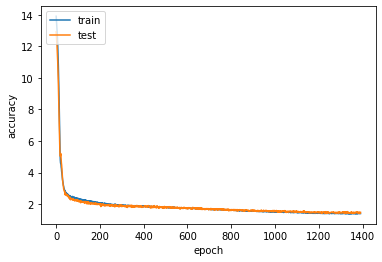

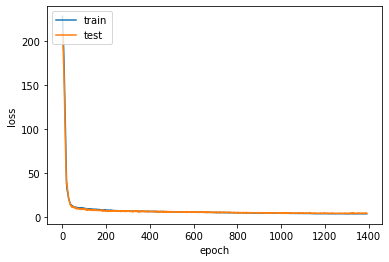

In [4]:
import matplotlib.pyplot as plt
# summarize history for accuracy
plt.plot(history.history['root_mean_squared_error'])
plt.plot(history.history['val_root_mean_squared_error'])
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [17]:
mean_rmses

[1.8161793994903563]

In [28]:
std_rmses

[0.1151273566847427,
 0.17471857257524775,
 0.15687872559715457,
 0.4648023274027273,
 0.31931690589403916]

In [6]:
import pickle

def save_obj(obj, name):
    with open(name, 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)
        
save_obj(mean_rmses, "../mean_rmse_dnn_MC.dat")
save_obj(std_rmses, "../std_rmse_dnn_MC.dat")


In [4]:
mc_pred=np.mean(pred,axis=0)
np.mean(mc_pred)

0.02413137

In [5]:
np.mean(np.std(pred,axis=1))

0.015234125

In [544]:
# list1 = [0.01,0.02,0.05,0.1, 0.2, 0.25,0.3,0.35]
# list2 = [5,6,7,8,9,10,11,12,15,20]

# from collections import OrderedDict
# param_grid = OrderedDict(rate = list1, node = list2)
    
# import itertools as it
# allNames = sorted(param_grid)
# combinations = it.product(*(param_grid[Name] for Name in allNames))
# param_combo_list = list(combinations)
# print(len(param_combo_list))
    
# std_list = []
# for it in np.arange(len(param_combo_list)):
#     pred = pass_arg(50, 20, param_combo_list[it])
#     mc_pred=np.mean(pred,axis=0)
#     std_list.append(np.std(pred,axis=1))
# #     print(param_combo_list[it],np.mean(mc_pred_sd))

In [545]:
# stdl = np.array(std_list)
# np.sort(np.mean(stdl,axis=1))

In [546]:
# stdl = np.array(std_list)
# # np.mean(stdl,axis=1)
# argss=np.argsort(np.mean(stdl,axis=1))
# combo = np.array(param_combo_list)
# combo[list(argss)]
# # pred

In [547]:
# mc_pred=np.mean(pred,axis=0)
# mc_pred_sd=np.std(pred,axis=1)
# np.mean(mc_pred_sd)

In [548]:
import pickle

def save_obj(obj, name):
    with open(name, 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)
        
save_obj(mc_pred, "../pred_dnn_MC_Xx1.dat")